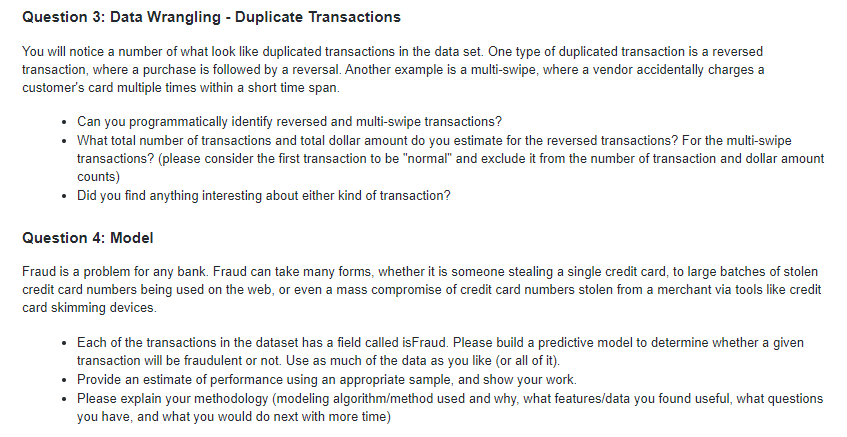

### Two data preprocessing steps done in the file before model building:

#### 1. Since the number of Fraud cases in the data are only about 1.5% we cant afford loosing a single row. Thus we fill NaNs in fruad cases using insights found during EDA and the then drop rows having NaNs from the majority class(non-Fraud cases)

#### 2. Feature Engineering done to transform data

##### customerId & accountNumber
- 'CustomerID' column and 'accountNumber' are similar, so we can keep just one to use as primary key for all transactions

##### creditLimit & availableMoney
- If 'creditLimit'=='availableMoney', then we can say that the user has the entire credit amount/credit power available for spending
- Thus a flag column can be created to denote if entire credit power available or no and the dropping the 'availableMoney' column

##### transactionDateTime
- Seperate columns for Year, Month, Day, Hour can be created from the 'transactionDateTime' column, but from EDA analysis we saw that there is no significant pattern and so can be dropped. There are almost equal number of fraud cases on any given day at any given time or month.

##### transactionAmount
- Normalized the data to fit the model

##### acqCountry & merchantCountryCode
- After checking if acqCountry==merchantCountyCode creating that as a flag, to capture the pattern if merchant country is different than acqCountry, does it affter fraud
- Since for both the columns 98% of the data is US, using that to fill NaN values for Fraud cases instead of removing rows. 

##### accountOpenDate & dateOfLastAddressChange
- Using accountOpenDate column to calculate age of data and converting date type column to numeric value
- After checking if dateOfLastAddressChange==accountOpenDate, which will help us capture if details given at the time of account opening were never changed or no. 
- Creating a binary flag, if information was changed and dropping dateOfLastAddressChange

##### Since 'cardCVV', 'enteredCVV', 'cardLast4Digits' are unique values like customerID, dropping those columns

- Creating a binary flag, if 'cardCVV'=='enteredCVV' or no and dropping both columns

##### transactionType
- Identifying reversal transaction and flagging the original transaction, that will help is marking transactions against which a reversal was processed.
- Removing rows having transactionType="REVERSAL" since that information is already captured in the flag created
- Now transactionType wil only have Purchase and Address Verification as unique values, so converting it into binary field.
- Removing multiswap transactions from the data, keeping only the first transaction value

#####  posEntryMode , posConditionCode & merchantCategoryCode
- One hot encoding the remaining categorical fields

##### *uncomment next line if imblearn library not installed

In [1]:
#pip install imblearn

In [2]:
#python required libraries

import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_columns = None
pd.options.display.max_rows = 55
from datetime import datetime as dt

#python feature engineering and preprocessing libraries

from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from numpy import loadtxt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.svm import SVC
from sklearn.decomposition import PCA 

from sklearn.metrics import accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay

### Loading data and data pre-processing

In [3]:
data = pd.read_json('transactions.txt',lines=True)
data['transactionDateTime'] = pd.to_datetime(data['transactionDateTime'])
data['accountOpenDate']=pd.to_datetime(data['accountOpenDate'])                                                                       

data.replace('',np.nan,inplace=True)
data.drop(['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip','posOnPremises',
           'recurringAuthInd','accountNumber'],axis=1,inplace=True)

In [4]:
data.head()

,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,False
1,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,True,False,False
2,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
3,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
4,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,True,False,False


### Replacing NaN values as 'PURCHASE' for Fraud cases since "mode" of transactionType for Fraud cases is PURCHASE

In [5]:
data.loc[(data["isFraud"] == True)&(data['transactionType'].isnull()),'transactionType']='PURCHASE'

### For most of the cases we see that 'acqCountry'=='merchantCountryCode' which is US, thus replacing NaN values for Fraud cases with US

In [6]:
data[data['isFraud']==True][['acqCountry','merchantCountryCode']].value_counts()

acqCountry  merchantCountryCode
US          US                     12122
MEX         MEX                       64
CAN         CAN                       55
PR          PR                        27
dtype: int64

In [7]:
data['acqCountry']= np.where((data['acqCountry'].isnull())&(data['isFraud']==True), 
                             data['merchantCountryCode'], data['acqCountry'])

data.loc[(data["isFraud"] == True)&(data['acqCountry'].isnull()),'acqCountry']='US'
data.loc[(data["isFraud"] == True)&(data['merchantCountryCode'].isnull()),'merchantCountryCode']='US'

### Doing the same for posCondition after checking if the "mode" value is same in the entire data and for Fraud cases. Replacing it with '01'

In [8]:
print(data[data['isFraud']==True]['posConditionCode'].value_counts().to_frame())
print(data['posConditionCode'].value_counts().to_frame())

    posConditionCode
01             10230
08              1936
99               229
    posConditionCode
01            628787
08            149634
99              7533


In [9]:
data.loc[(data["isFraud"] == True)&(data['posConditionCode'].isnull()),'posConditionCode']='01'

### Following the same process for posEntryMode but we see that the "mode" is different for the entire data and for Fraud cases.

In [10]:
print(data[data['isFraud']==True][['posEntryMode']].value_counts().to_frame())
print(data['posEntryMode'].value_counts().to_frame())

                 0
posEntryMode      
09            5659
02            3421
05            2456
90             372
80             240
    posEntryMode
05        315035
09        236481
02        195934
90         19576
80         15283


### But top merchantCategoryCode for Fraud cases are all online transactions and entryCode '09' stands for 'PAN entry via e-commerce' thus, replacing NaNs with '09'

In [11]:
data[data['isFraud']==True][['merchantCategoryCode']].value_counts()

merchantCategoryCode
online_retail           4938
online_gifts            1606
rideshare               1272
fastfood                1074
food                    1014
entertainment            961
airline                  534
auto                     273
hotels                   250
subscriptions            216
furniture                103
health                    90
personal care             86
dtype: int64

In [12]:
data.loc[(data["isFraud"] == True)&(data['posEntryMode'].isnull()),'posEntryMode']='09'

### Checking for null values in Fraud cases. Removing rows having NaN value for non-Fraud cases.

In [13]:
data[data['isFraud']==True].isnull().sum()

customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
currentBalance              0
cardPresent                 0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64

In [14]:
data.dropna(inplace=True)

### Final check for null values in the entire data.

In [15]:
data.isnull().sum()

customerId                  0
creditLimit                 0
availableMoney              0
transactionDateTime         0
transactionAmount           0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
currentExpDate              0
accountOpenDate             0
dateOfLastAddressChange     0
cardCVV                     0
enteredCVV                  0
cardLast4Digits             0
transactionType             0
currentBalance              0
cardPresent                 0
expirationDateKeyInMatch    0
isFraud                     0
dtype: int64

In [16]:
data.columns

Index(['customerId', 'creditLimit', 'availableMoney', 'transactionDateTime',
       'transactionAmount', 'merchantName', 'acqCountry',
       'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch', 'isFraud'],
      dtype='object')

### To check where a vendor accidentally charges a customer's card multiple times within a short time span:

    1. Grouping data by customerID and then sorting transactionDateTime
    2. Checking if there are groups of transaction under 3 mins
    3. If yes, marking first value as False and others as True
    4. Dropping all the rows in multiswap column marked as True


In [17]:
data['multiswap'] = (data.sort_values(['transactionDateTime'])
                    .groupby(['customerId', 'creditLimit',  'transactionAmount', 'merchantName',
                              'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
                              'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
                              'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
                              'transactionType', 'cardPresent',
                              'expirationDateKeyInMatch'],sort=False)['transactionDateTime'].diff().dt.total_seconds().lt(300))

In [18]:
data['multiswap'].value_counts()

False    769560
True       7559
Name: multiswap, dtype: int64

### Checking if any multiswap duplicated transactions which we are going to drop are reversals also because we might loose that information when we remove multiswap duplicate rows

In [19]:
len(data[(data['multiswap']==True)&(data['transactionType']=='REVERSAL')])

0

In [20]:
data.drop(data[data['multiswap']==True].index, inplace = True)

### For duplicated transaction is a reversed transaction:

    1. Creating a table with only reversal transactions
    2. Doing left join with the original table on all columns except transactionType column
    3. Removing rows where transactionType is reversal from original data
    

In [21]:
reversal_transaction = data[data['transactionType']=='REVERSAL']
len(reversal_transaction)

20075

In [22]:
data = data.merge(reversal_transaction,on=['customerId', 'creditLimit', 'transactionAmount', 'merchantName',
                    'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode','dateOfLastAddressChange','cardPresent',
                   'merchantCategoryCode', 'currentExpDate', 'accountOpenDate', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
                   'expirationDateKeyInMatch','isFraud'],how='left',suffixes=("","_Y"))

In [23]:
data.drop(data[data['transactionType']==data['transactionType_Y']].index,inplace=True)

#### Data Checks

In [24]:
data['transactionType'].value_counts()

PURCHASE                729731
ADDRESS_VERIFICATION     19754
Name: transactionType, dtype: int64

In [25]:
data['transactionType_Y'].value_counts()

REVERSAL    15805
Name: transactionType_Y, dtype: int64

#### Once all the rows are dopped having reversal transaction in the original transactionType column, we do a final data check to see how many rows could do the left join.
#### About ~15k rows out of ~20k reversal transaction found the original transaction.

### Flagging original transactions which were reversed.

In [26]:
data['reversed'] = np.where(data['transactionType_Y']=='REVERSAL',1,0)

### Dropping extra columns created after the join

In [27]:
data.drop(['availableMoney_Y','transactionDateTime_Y', 'transactionType_Y', 'currentBalance_Y','multiswap_Y','multiswap'],axis=1,inplace=True)
#data['cardPresent','expirationDateKeyInMatch',
#     'isFraud''multiswap'] = data.astype({'cardPresent': int,'expirationDateKeyInMatch': int,'isFraud': int}) 

In [28]:
data[['cardPresent','expirationDateKeyInMatch','isFraud']] = data[['cardPresent',
                                                                   'expirationDateKeyInMatch','isFraud']].astype(int)


 ### Creating a flag if 'cardCVV' == 'enteredCVV' column match.

In [29]:
data['cvvmatch'] = np.where(data['cardCVV']==data['enteredCVV'],1,0)

In [30]:
data[['isFraud','cvvmatch']].value_counts()

isFraud  cvvmatch
0        1           731042
1        1            11759
0        0             6491
1        0              193
dtype: int64

#### Creating a flag if entire 'creditLimit' was available for use

#### Creating a flag to check if 'acqCountry' =='merchantCountryCode' so that both the columns can be dropped, because then we will know that the transaction is not made in the same country of credit card or no

#### Creating a flag to check if 'accountOpenDate' == 'dateOfLastAddressChange', meaning that information was never changed so that we can drop 'dateOfLastAddressChange' column


In [31]:
data['100%creditAvailable'] = np.where((data['currentBalance']==0)&(data['creditLimit']==data['availableMoney']),1,0)

In [32]:
data['sameAcqMerchantCountry']=np.where(data['acqCountry']==data['merchantCountryCode'],1,0)

In [33]:
data['addressEverChange']=np.where(data['accountOpenDate']==data['dateOfLastAddressChange'],0,1)

In [34]:
data.head(5)

,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,reversed,cvvmatch,100%creditAvailable,sameAcqMerchantCountry,addressEverChange
0,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,0,0,0,0,1,1,1,0
1,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,1,0,0,0,1,1,1,0
2,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,0,0,0,0,1,1,1,0
3,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,0,0,0,0,1,1,1,0
4,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,1,0,0,0,1,1,1,0


### Calculating the age of accounts using the 'accountOpenDate' column and then binning the column.
#### the difference is taken between account opening date and the last month of transaction timestamp, which is December 2016

In [35]:
data['accountAge'] = ((pd.to_datetime('2016-12-31')-data['accountOpenDate'])/np.timedelta64(1, 'M'))

In [36]:
data['accountAge'].describe()

count    749485.000000
mean         34.899649
std          22.640207
min          12.024888
25%          19.942915
50%          27.893797
75%          42.087107
max         328.318857
Name: accountAge, dtype: float64

<AxesSubplot:xlabel='accountAge', ylabel='Count'>

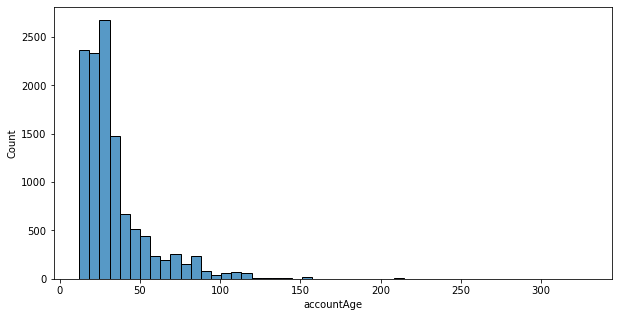

In [37]:
plt.figure(figsize=(10,5))
sns.histplot(data=data[data['isFraud']==True], x='accountAge',bins=50,stat='count')

### From above graphs we see that there are more Fraud cases with leasser account age between most of the data points between 12-27 months.

In [38]:
data.head()

,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,reversed,cvvmatch,100%creditAvailable,sameAcqMerchantCountry,addressEverChange,accountAge
0,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,0,0,0,0,1,1,1,0,21.618514
1,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,1,0,0,0,1,1,1,0,21.618514
2,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,0,0,0,0,1,1,1,0,21.618514
3,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,0,0,0,0,1,1,1,0,21.618514
4,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,1,0,0,0,1,1,1,0,16.854556


### Creating a binary column for Transation Type since only two values present, Address Verfication and Purchase & One-hot encoding other categorical columns

In [39]:
dummy_cat = ['merchantCategoryCode','transactionType','posEntryMode','posConditionCode']

dummy = pd.get_dummies(data[['merchantCategoryCode','transactionType','posEntryMode','posConditionCode']])

In [41]:
transformer = Normalizer().fit(data[['creditLimit','transactionAmount','accountAge']])
data[['creditLimit','transactionAmount','accountAge']] = transformer.transform(data[['creditLimit','transactionAmount',
                                                              'accountAge']])

In [43]:
data[dummy.columns] = dummy[dummy.columns]

In [44]:
data.head()

,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,reversed,cvvmatch,100%creditAvailable,sameAcqMerchantCountry,addressEverChange,accountAge,merchantCategoryCode_airline,merchantCategoryCode_auto,merchantCategoryCode_cable/phone,merchantCategoryCode_entertainment,merchantCategoryCode_fastfood,merchantCategoryCode_food,merchantCategoryCode_food_delivery,merchantCategoryCode_fuel,merchantCategoryCode_furniture,merchantCategoryCode_gym,merchantCategoryCode_health,merchantCategoryCode_hotels,merchantCategoryCode_mobileapps,merchantCategoryCode_online_gifts,merchantCategoryCode_online_retail,merchantCategoryCode_online_subscriptions,merchantCategoryCode_personal care,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions,transactionType_ADDRESS_VERIFICATION,transactionType_PURCHASE,posEntryMode_02,posEntryMode_05,posEntryMode_09,posEntryMode_80,posEntryMode_90,posConditionCode_01,posConditionCode_08,posConditionCode_99
0,737265056,0.999796,5000.0,2016-08-13 14:27:32,0.019706,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,0,0,0,0,1,1,1,0,0.004323,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0
1,737265056,0.999880,5000.0,2016-10-11 05:05:54,0.014900,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,1,0,0,0,1,1,1,0,0.004323,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
2,737265056,0.999990,5000.0,2016-11-08 09:18:39,0.001494,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,0,0,0,0,1,1,1,0,0.004324,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
3,737265056,0.999990,5000.0,2016-12-10 02:14:50,0.001494,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,0,0,0,0,1,1,1,0,0.004324,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
4,830329091,0.999893,5000.0,2016-03-24 21:04:46,0.014234,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,1,0,0,0,1,1,1,0,0.003371,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0


In [45]:
data.columns

Index(['customerId', 'creditLimit', 'availableMoney', 'transactionDateTime',
       'transactionAmount', 'merchantName', 'acqCountry',
       'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch', 'isFraud', 'reversed', 'cvvmatch',
       '100%creditAvailable', 'sameAcqMerchantCountry', 'addressEverChange',
       'accountAge', 'merchantCategoryCode_airline',
       'merchantCategoryCode_auto', 'merchantCategoryCode_cable/phone',
       'merchantCategoryCode_entertainment', 'merchantCategoryCode_fastfood',
       'merchantCategoryCode_food', 'merchantCategoryCode_food_delivery',
       'merchantCategoryCode_fuel', 'merchantCategoryCode_furniture',
       'merchantCategoryCode_gym', 'merchantCategoryCode_health',
       'merchantCategoryCode_hotel

#### Dropping columns we don't need

In [46]:
data.drop(['customerId', 'availableMoney','currentBalance', 'transactionDateTime', 'merchantName', 'acqCountry',
       'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'transactionType_ADDRESS_VERIFICATION',
          'merchantCategoryCode_airline','merchantCategoryCode_auto', 'merchantCategoryCode_cable/phone',
           'merchantCategoryCode_food_delivery','merchantCategoryCode_fuel', 'merchantCategoryCode_furniture',
       'merchantCategoryCode_gym', 'merchantCategoryCode_health',
       'merchantCategoryCode_hotels', 'merchantCategoryCode_mobileapps',
       'merchantCategoryCode_online_subscriptions','merchantCategoryCode_personal care', 'merchantCategoryCode_rideshare',
       'merchantCategoryCode_subscriptions','posEntryMode_80', 'posEntryMode_90','posConditionCode_99'],axis=1,inplace=True)

In [47]:
data.columns

Index(['creditLimit', 'transactionAmount', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch', 'isFraud', 'reversed', 'cvvmatch',
       '100%creditAvailable', 'sameAcqMerchantCountry', 'addressEverChange',
       'accountAge', 'merchantCategoryCode_entertainment',
       'merchantCategoryCode_fastfood', 'merchantCategoryCode_food',
       'merchantCategoryCode_online_gifts',
       'merchantCategoryCode_online_retail', 'transactionType_PURCHASE',
       'posEntryMode_02', 'posEntryMode_05', 'posEntryMode_09',
       'posConditionCode_01', 'posConditionCode_08'],
      dtype='object')

In [48]:
len(data),len(data.columns)

(749485, 23)

### Classification Prediction Model

In [49]:
y=data['isFraud']
X=data.drop(['isFraud'],axis=1)
X = X.apply(pd.to_numeric)

In [80]:
#checking null values
X.isnull().sum()

transactionAmount                     0
cardPresent                           0
expirationDateKeyInMatch              0
reversed                              0
100%creditAvailable                   0
addressEverChange                     0
accountAge                            0
merchantCategoryCode_entertainment    0
merchantCategoryCode_fastfood         0
merchantCategoryCode_food             0
merchantCategoryCode_online_gifts     0
merchantCategoryCode_online_retail    0
posEntryMode_02                       0
posEntryMode_05                       0
posEntryMode_09                       0
dtype: int64

### Calculating VIF to check multi-collinearity which is a common disadvantage of on-hot encoding. Removing columns with VIF>15

In [51]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                               feature          VIF
0                          creditLimit   705.798546
1                    transactionAmount     3.346434
2                       currentBalance    32.605250
3                          cardPresent     4.624797
4             expirationDateKeyInMatch     1.003028
5                             reversed     1.022145
6                             cvvmatch   111.164887
7                  100%creditAvailable     1.300045
8               sameAcqMerchantCountry  1194.074525
9                    addressEverChange     2.377001
10                          accountAge     1.562680
11  merchantCategoryCode_entertainment     1.557786
12       merchantCategoryCode_fastfood     1.862045
13           merchantCategoryCode_food     1.580948
14   merchantCategoryCode_online_gifts     1.425612
15  merchantCategoryCode_online_retail     2.271180
16            transactionType_PURCHASE    40.334696
17                     posEntryMode_02     6.600930
18          

In [52]:
high_VIF = list(vif_data[vif_data['VIF']>15]['feature'].values)

In [53]:
X.drop(high_VIF,axis=1,inplace=True)

In [54]:
X.columns

Index(['transactionAmount', 'cardPresent', 'expirationDateKeyInMatch',
       'reversed', '100%creditAvailable', 'addressEverChange', 'accountAge',
       'merchantCategoryCode_entertainment', 'merchantCategoryCode_fastfood',
       'merchantCategoryCode_food', 'merchantCategoryCode_online_gifts',
       'merchantCategoryCode_online_retail', 'posEntryMode_02',
       'posEntryMode_05', 'posEntryMode_09'],
      dtype='object')

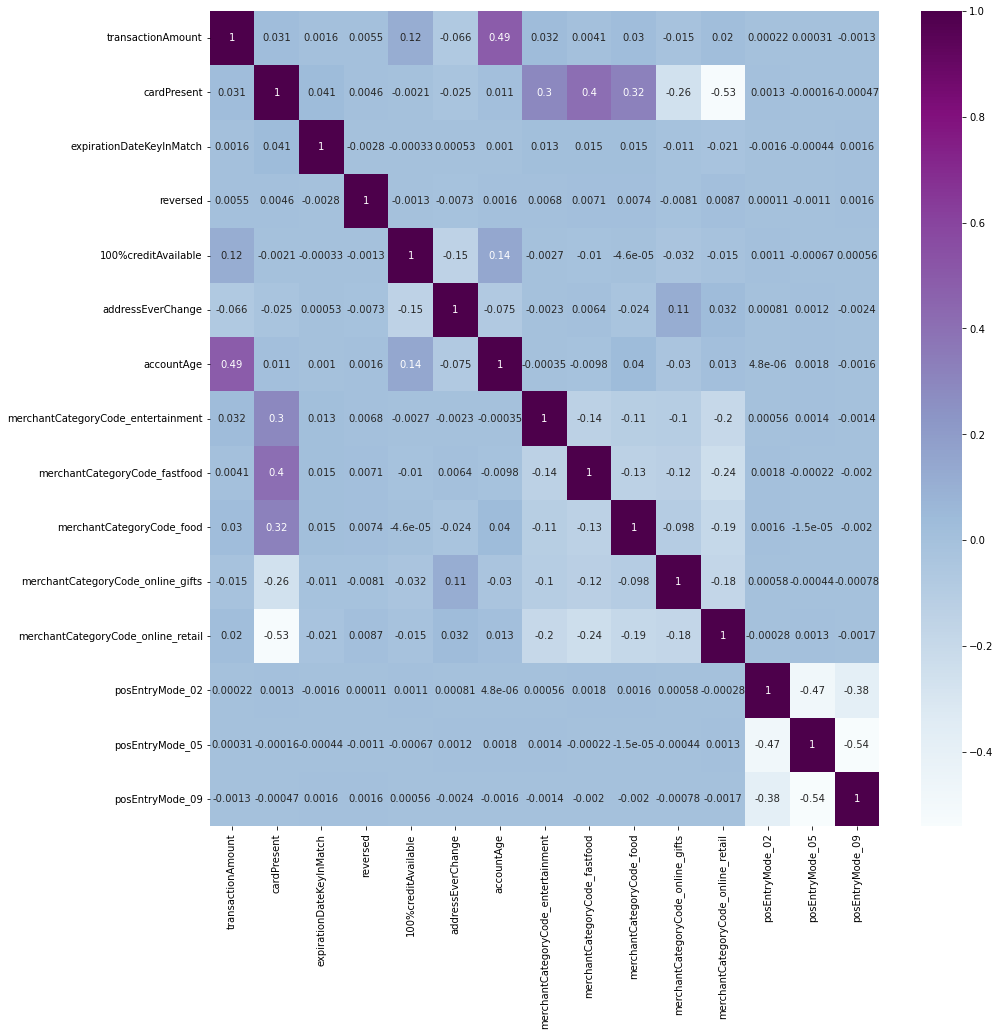

In [81]:
#Plotting correlation matrix
plt.figure(figsize=(15,15)) 
sns.heatmap(data=X.corr(),cmap='BuPu',annot=True)
plt.show()

In [56]:
X.describe()

,transactionAmount,cardPresent,expirationDateKeyInMatch,reversed,100%creditAvailable,addressEverChange,accountAge,merchantCategoryCode_entertainment,merchantCategoryCode_fastfood,merchantCategoryCode_food,merchantCategoryCode_online_gifts,merchantCategoryCode_online_retail,posEntryMode_02,posEntryMode_05,posEntryMode_09
count,749485.000000,749485.000000,749485.000000,749485.000000,749485.000000,749485.000000,749485.000000,749485.000000,749485.000000,749485.000000,749485.000000,749485.000000,749485.000000,749485.000000,749485.000000
mean,0.043071,0.448320,0.001338,0.021088,0.043738,0.524172,0.012777,0.101514,0.142084,0.095576,0.084040,0.256463,0.250347,0.402644,0.302393
std,0.105956,0.497322,0.036558,0.143677,0.204512,0.499416,0.031407,0.302008,0.349137,0.294009,0.277449,0.436681,0.433213,0.490431,0.459295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000176,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.003260,0.000000,0.000000,0.000000,0.000000,0.000000,0.001686,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.010639,0.000000,0.000000,0.000000,0.000000,1.000000,0.003839,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.031211,1.000000,0.000000,0.000000,0.000000,1.000000,0.008103,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,0.985959,1.000000,1.000000,1.000000,1.000000,1.000000,0.632598,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Undersampling the data to handle imbalance of data

In [57]:
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
x_new, y_new = rus.fit_resample(X, y)

In [58]:
len(x_new),len(y_new),len(X), len(y)

(23904, 23904, 749485, 749485)

In [59]:
y_new.value_counts()

0    11952
1    11952
Name: isFraud, dtype: int64

### Splitting data into test and train data

In [60]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, test_size=0.3, random_state=42)

### Experimenting with classification models with grid search
#### 1. Logistic Regression
#### 2. XGBoost
#### 3. Support Vector Machine/SVM

In [61]:
# LOGISTIC REGRESSION #

params = {
    'penalty': ['l2'],
    'C': [0.01, 0.1, 1, 10,100],
    'n_jobs': [-1],
    'solver' :['saga']
}
grid1 = GridSearchCV(estimator=LogisticRegression(max_iter=1000), param_grid=params, cv=5)
grid1.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END C=0.01, n_jobs=-1, penalty=l2, solver=saga;, score=0.646 total time=   2.2s
[CV 2/5] END C=0.01, n_jobs=-1, penalty=l2, solver=saga;, score=0.651 total time=   0.4s
[CV 3/5] END C=0.01, n_jobs=-1, penalty=l2, solver=saga;, score=0.657 total time=   0.3s
[CV 4/5] END C=0.01, n_jobs=-1, penalty=l2, solver=saga;, score=0.638 total time=   0.3s
[CV 5/5] END C=0.01, n_jobs=-1, penalty=l2, solver=saga;, score=0.641 total time=   0.4s
[CV 1/5] END C=0.1, n_jobs=-1, penalty=l2, solver=saga;, score=0.644 total time=   0.3s
[CV 2/5] END C=0.1, n_jobs=-1, penalty=l2, solver=saga;, score=0.651 total time=   0.3s
[CV 3/5] END C=0.1, n_jobs=-1, penalty=l2, solver=saga;, score=0.654 total time=   0.3s
[CV 4/5] END C=0.1, n_jobs=-1, penalty=l2, solver=saga;, score=0.644 total time=   0.1s
[CV 5/5] END C=0.1, n_jobs=-1, penalty=l2, solver=saga;, score=0.646 total time=   0.1s
[CV 1/5] END C=1, n_jobs=-1, penalty=l2, solver=saga;, 

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'n_jobs': [-1],
                         'penalty': ['l2'], 'solver': ['saga']},
             verbose=3)

In [70]:
# XGBoost #

params = {
        'n_estimators': [50, 70],
        'max_depth': [3, 5,7],
        'learning_rate': [0.01, 0.05, 0.1],
        'reg_alpha': [ 0.5, 1],
        'reg_lambda': [ 0.5, 1],
        'n_jobs': [-1]}

grid2 = GridSearchCV(estimator=XGBClassifier(), param_grid=params, cv=5)

grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 70],
                         'n_jobs': [-1], 'reg_alpha': [0.5, 1],
                         'reg_lambda': [0.5, 1]})

In [67]:
# SVM #

params = {
    'C': [0.01, 0.1, 1, 10],
    'gamma': ['scale'],
    'kernel': ['poly', 'rbf']}

grid3 = GridSearchCV(estimator=SVC(probability=True), param_grid=params, cv=5)

grid3.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [0.01, 0.1, 1, 10], 'gamma': ['scale'],
                         'kernel': ['poly', 'rbf']})

#### Best Paramters

In [106]:
d1=pd.DataFrame(grid1.best_params_.values(),index=grid1.best_params_.keys(),columns=['Best Paramters'])
d1['Model'] = 'Logistic Regression'
d2=pd.DataFrame(grid2.best_params_.values(),index=grid2.best_params_.keys(),columns=['Best Paramters'])
d2['Model'] = 'XGBoost'
d3=pd.DataFrame(grid3.best_params_.values(),index=grid3.best_params_.keys(),columns=['Best Paramters'])
d3['Model'] = 'SVM'

In [107]:
pd.concat([d1,d2,d3])

,Best Paramters,Model
C,100,Logistic Regression
n_jobs,-1,Logistic Regression
penalty,l2,Logistic Regression
solver,saga,Logistic Regression
learning_rate,0.1,XGBoost
max_depth,7.0,XGBoost
n_estimators,70.0,XGBoost
n_jobs,-1.0,XGBoost
reg_alpha,0.5,XGBoost
reg_lambda,0.5,XGBoost


#### Accuracies

In [75]:
print('Best Score for Logistic Regression is : ', grid1.best_score_)
print('Best Score for XGBoost is : ', grid2.best_score_)
print('Best Score for SVM is : ', grid3.best_score_)

Best Score for Logistic Regression is :  0.6514462729110706
Best Score for XGBoost is :  0.7008131931049225
Best Score for SVM is :  0.6443938965602654


In [72]:
y_pred1 = grid1.predict(X_test)
y_pred2 = grid2.predict(X_test)
y_pred3 = grid3.predict(X_test)

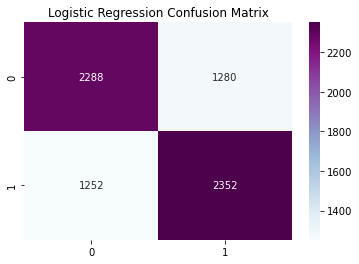

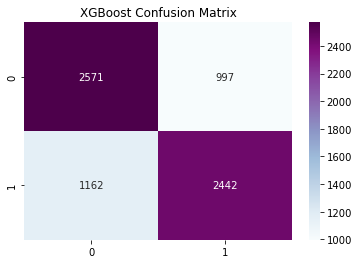

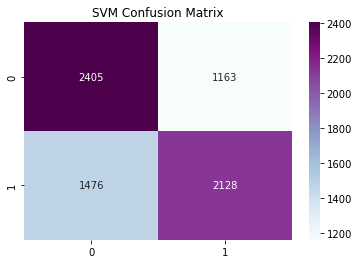

In [96]:
sns.heatmap(data=confusion_matrix(y_test, y_pred1),cmap='BuPu',annot=True,fmt='d').set_title("Logistic Regression Confusion Matrix")
plt.show()
sns.heatmap(data=confusion_matrix(y_test, y_pred2),cmap='BuPu',annot=True,fmt='d').set_title("XGBoost Confusion Matrix")
plt.show()
sns.heatmap(data=confusion_matrix(y_test, y_pred3),cmap='BuPu',annot=True,fmt='d').set_title("SVM Confusion Matrix")
plt.show()

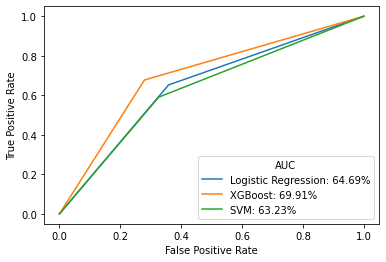

In [91]:
# calculate roc curves
fpr1, tpr1, _ = metrics.roc_curve(y_test, y_pred1)
fpr2, tpr2, _ = metrics.roc_curve(y_test, y_pred2)
fpr3, tpr3, _ = metrics.roc_curve(y_test, y_pred3)

auc1 = round(metrics.roc_auc_score(y_test, y_pred1)*100,2)
auc2 = round(metrics.roc_auc_score(y_test, y_pred2)*100,2)
auc3 = round(metrics.roc_auc_score(y_test, y_pred3)*100,2)

# plot the roc curve for the model
plt.plot(fpr1, tpr1, label='Logistic Regression: '+str(auc1)+"%")
plt.plot(fpr2, tpr2, label='XGBoost: '+str(auc2)+"%")
plt.plot(fpr3, tpr3, label='SVM: '+str(auc3)+"%")

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend(title='AUC')
# show the plot
plt.show()

## Conclusion